In [1]:
import pandas as pd 
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
df_heart = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [3]:
df_heart.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


All of these predictors seem mildly important in determining a doctor's diagnosis of a heart attack. I will run a first model with all of these variables and adjust what seems necessary based on coefficients.

**Part 1: Fitting Models**

In [4]:
ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "drop"
)

**Q1: KNN**

In [5]:
# First model with all variables.

X = df_heart.drop("output", axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("kNN", KNeighborsClassifier())]
).set_output(transform="pandas")

neighbors = {'kNN__n_neighbors': [1, 3, 5, 7, 15]}

gscv = GridSearchCV(pipeline, neighbors, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

In [6]:
# Trying all sorts of different options - the final ouput shown is the best ROC AUC

X = df_heart.drop(["output", "restecg", "chol"], axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("kNN", KNeighborsClassifier())]
).set_output(transform="pandas")

neighbors = {'kNN__n_neighbors': [1, 3, 5, 7, 15]}

gscv = GridSearchCV(pipeline, neighbors, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=1)

,kNN__n_neighbors,scores
4,15,0.853045


The model, using all of the predictors besides resting electrocardiographic results and cholesterol gave a cross-validated ROC AUC score of 0.853.

In [7]:
pipeline = Pipeline(
  [("selection", ct),
  ("kNN", KNeighborsClassifier(n_neighbors=15))]
).set_output(transform="pandas")

In [8]:
y_prob = cross_val_predict(pipeline, X, y, cv=5, method="predict_proba")[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

roc_data = pd.DataFrame({
    "method": "KNN",
    "FPR": fpr,
    "TPR": tpr
})

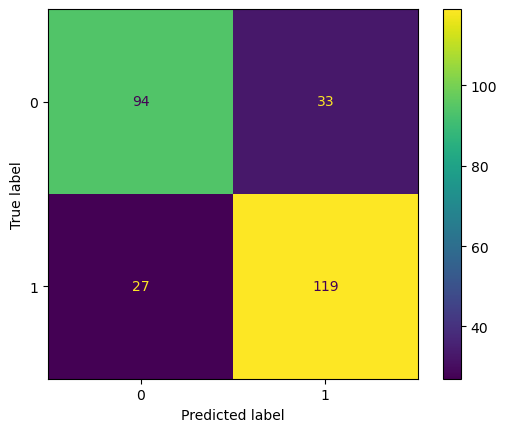

In [9]:
y_pred = cross_val_predict(pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

It is not applicable to interpret coefficients with a KNN model.

**Q2: Logistic Regression**

In [10]:
# First model with all variables.

X = df_heart.drop("output", axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("log", LogisticRegression())]
).set_output(transform="pandas")

reg_terms = {"log__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

gscv = GridSearchCV(pipeline, reg_terms, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

In [11]:
# Trying all sorts of different variable combinations. Output shown is the best model.

X = df_heart.drop(["output", "restecg", "age"], axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("log", LogisticRegression())]
).set_output(transform="pandas")

reg_terms = {"log__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

gscv = GridSearchCV(pipeline, reg_terms, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=1)

,log__C,scores
4,10.0,0.859289


The model, using all of the predictors besides resting electrocardiographic results and age, gave a cross-validated ROC AUC score of 0.8593.

In [12]:
pipeline = Pipeline(
  [("selection", ct),
  ("log", LogisticRegression(C=10))]
).set_output(transform="pandas")

In [ ]:
y_prob = cross_val_predict(pipeline, X, y, cv=5, method="predict_proba")[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

temp_data = pd.DataFrame({
    "method": "Logistic Regression",
    "FPR": fpr,
    "TPR": tpr
})

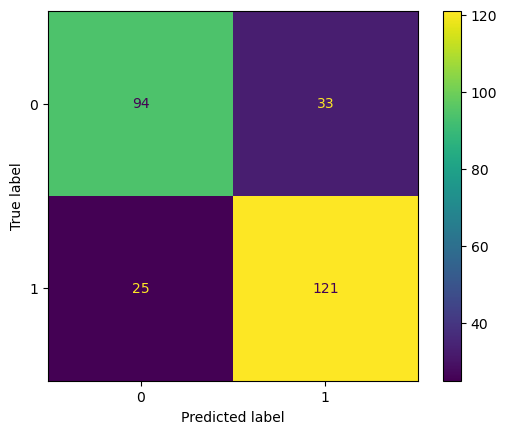

In [14]:
y_pred = cross_val_predict(pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

In [15]:
pipeline = Pipeline(
  [("selection", ct),
  ("logestic_regression", LogisticRegression(C=10))]
).set_output(transform="pandas")

pipeline.fit(X, y)
logistic_regression_model = pipeline.named_steps["logestic_regression"]

coef = logistic_regression_model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})

coef_df

,Feature,Coefficient
0,sex,-0.988176
1,cp,0.881753
2,trtbps,-0.483509
3,chol,-0.341750
4,thalach,1.013340


A higher chest pain increases your odds of having a heart attack; same with maximum heart rate achieved during exercise. A higher resting blood pressure decreases your odds of having a heart attack; same with cholesterol. Being a female is associated with less of a risk of heart attack as being male.

**Q3: Decision Tree**

In [16]:
# First model with all variables.

X = df_heart.drop("output", axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("tree", DecisionTreeClassifier())]
).set_output(transform="pandas")

alphas = {"tree__ccp_alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10]}

gscv = GridSearchCV(pipeline, alphas, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

In [17]:
# Trying all sorts of different variable combinations. Output shown is the best model.

X = df_heart.drop(["output", "thalach"], axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("tree", DecisionTreeClassifier())]
).set_output(transform="pandas")

alphas = {"tree__ccp_alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10]}

gscv = GridSearchCV(pipeline, alphas, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=1)

,tree__ccp_alpha,scores
1,0.01,0.783892


The model, using all of the predictors besides maximum heart rate during exercise, gave a cross-validated ROC AUC score of 0.784.

In [18]:
pipeline = Pipeline(
  [("selection", ct),
  ("tree", DecisionTreeClassifier(ccp_alpha=0.01))]
).set_output(transform="pandas")

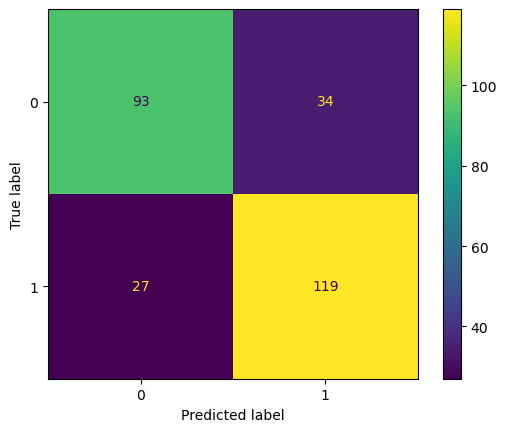

In [19]:
y_pred = cross_val_predict(pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

**Q4: Interpretations**

In my observations, the most important variables were the predictors that were always adding value to the different models I tested (each with varying feature sets not shown in the rendered document).

Sex, chest pain type and resting blood pressure were the three most important variables by that qualitative measure. Based on the choice of model, where KNN, Decision Tree, etc., one of the other predictor variables in the dataset worsened the cross-validated ROC AUC score.

**Q5: ROC Curve**